Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

**Importing all the important libraries**

In [1]:
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from glob import glob

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
data_dir_train = pathlib.Path("/content/gdrive/My Drive/Train")
data_dir_test = pathlib.Path('/content/gdrive/My Drive/Test')

In [4]:

image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


**Load using keras.preprocessing**

Let's load these images off disk using the helpful image_dataset_from_directory utility.

**Create a dataset**

In [5]:
batch_size = 32
image_height = 180
image_width = 180
# Set the random seed for reproducibility
seed = 123

In [6]:
# Use 80% of the images for training, and 20% for validation.
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    image_size= (image_height, image_width),
    batch_size = batch_size,
    seed = seed,
    validation_split=0.2,
    subset = "training",
)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [7]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_test,
    image_size = (image_height, image_width),
    batch_size = batch_size,
    seed = seed,
    validation_split=0.2,
    subset = "validation",
)

Found 118 files belonging to 9 classes.
Using 23 files for validation.


In [8]:
class_names = train_ds.class_names
class_numbers = len(class_names)
print(class_numbers)
print(class_names)

9
['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


**Visualize the data**

 visualize one instance of all the nine classes present in the dataset

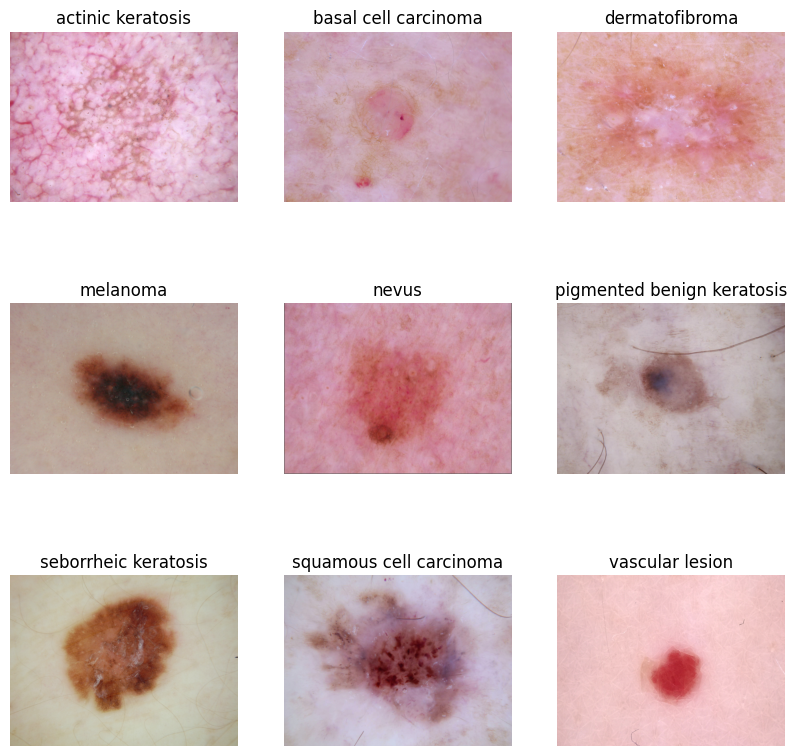

In [9]:
plt.figure(figsize=(10,10))
for lesion_type in range(class_numbers):
  class_path = glob(os.path.join(data_dir_train, class_names[lesion_type], '*'))
  lesion_imgs = list(class_path)
  # Open the first image in the class
  img = PIL.Image.open(lesion_imgs[0])
  ax = plt.subplot(3,3, lesion_type+1)
  plt.imshow(img)
  plt.title(class_names[lesion_type])
  plt.axis("off")

The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
cached_train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
cached_val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

**Create the model**

In [11]:
num_classes = 9


model = Sequential([
  tf.keras.layers.InputLayer(input_shape=(image_height, image_width, 3)),
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)

])

In [12]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 32)        9

**Train the model**

In [14]:
epochs = 20
history = model.fit(
  cached_train_ds,
  validation_data=cached_val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 [==============================] - 781s 52ms/step - loss: 1.8103 - accuracy: 0.3162 - val_loss: 2.1849 - val_accuracy: 0.3478
Epoch 2/20
169/169 [==============================] - 4s 22ms/step - loss: 1.4349 - accuracy: 0.4562 - val_loss: 2.4298 - val_accuracy: 0.1739
Epoch 3/20
169/169 [==============================] - 4s 22ms/step - loss: 1.2370 - accuracy: 0.5313 - val_loss: 2.6216 - val_accuracy: 0.1304
Epoch 4/20
169/169 [==============================] - 4s 22ms/step - loss: 1.0713 - accuracy: 0.6046 - val_loss: 2.5051 - val_accuracy: 0.1739
Epoch 5/20
169/169 [==============================] - 4s 22ms/step - loss: 0.9740 - accuracy: 0.6445 - val_loss: 3.0646 - val_accuracy: 0.2609
Epoch 6/20
169/169 [==============================] - 4s 22ms/step - loss: 0.7901 - accuracy: 0.7072 - val_loss: 2.7298 - val_accuracy: 0.3478
Epoch 7/20
169/169 [==============================] - 4s 22ms/step - loss: 0.7135 - accuracy: 0.7430 - val_loss: 4.1862 - val_accuracy: 0.26

**Visualizing training results**

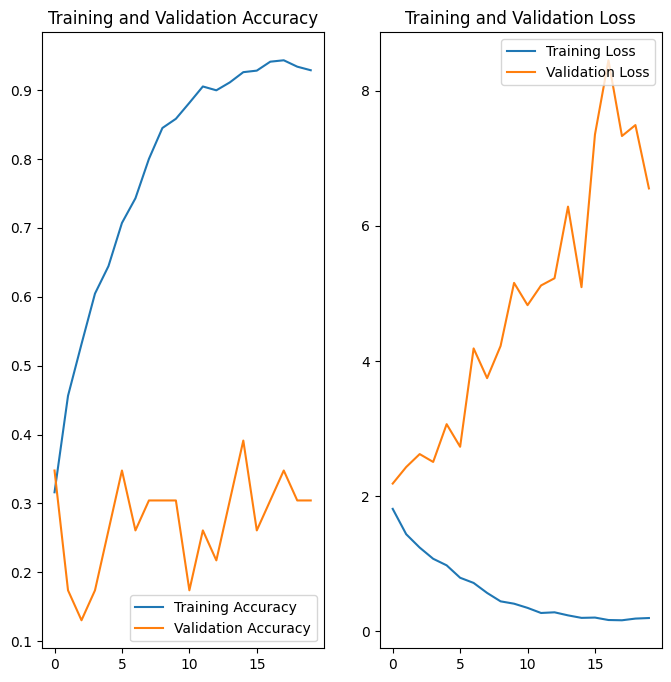

In [15]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Observations**

It is clear evidence of overfitting with the difference between training accuracy and validation accuracy being greater than 0.5. In addition, as can be observed in the graphs above, as training proceeds, while training loss decreases, validation loss increases.

**Data Augmentation**

**Creation of data augmentation layer architecture for reuse**

In [16]:
pip install keras_cv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.1/803.1 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 62.2 MB/s eta 0:00:00


In [17]:
import keras_cv

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.5),
    layers.RandomContrast(0.5),
    layers.RandomBrightness(0.3),
    keras_cv.layers.RandomColorDegeneration(0.5)
])

Using TensorFlow backend


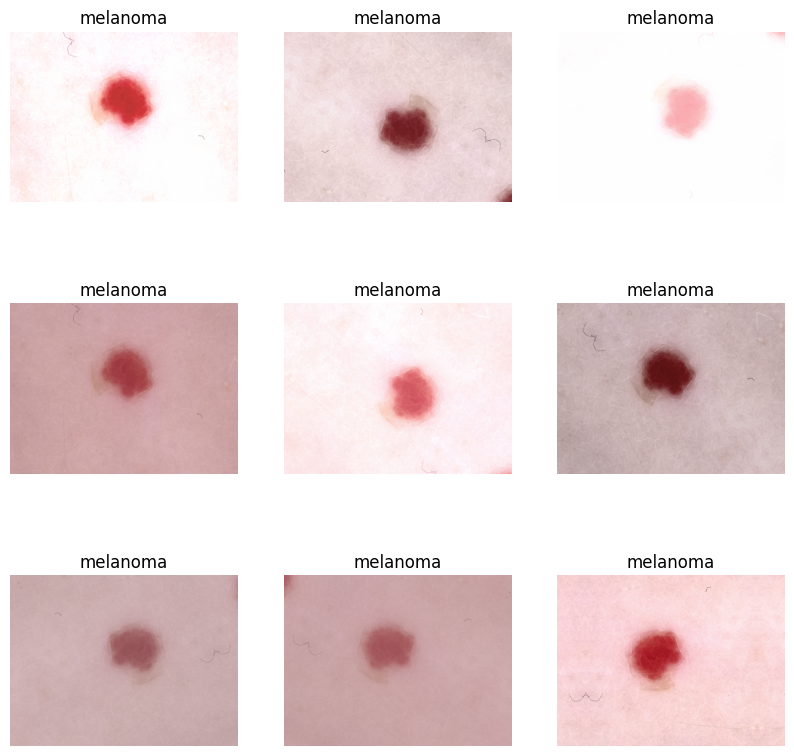

In [18]:
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
  for i in range(9):
    augmented_image = data_augmentation(img)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image.numpy().astype("uint8"))
    plt.title(class_names[labels[1]])
    plt.axis("off")

**Model Creation with Augmentation and Dropout layers**

adding  dropout layers as well as with the data augmentation layers.

In [19]:
dropout_conv = 0.05
dropout_dense = 0.25

model_aug_drop = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(image_height, image_width,3)),
    data_augmentation,
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(dropout_conv),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(dropout_conv),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(dropout_conv),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(dropout_dense),
    tf.keras.layers.Dense(num_classes)
])

**Model Compilation**

In [20]:
model_aug_drop.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 32)        9

**Model Training**

In [22]:
epochs = 20 # As specified in the project pipeline
history = model_aug_drop.fit(
  cached_train_ds,
  validation_data = cached_val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 [==============================] - 16s 63ms/step - loss: 2.0587 - accuracy: 0.2001 - val_loss: 2.1190 - val_accuracy: 0.2174
Epoch 2/20
169/169 [==============================] - 9s 54ms/step - loss: 1.8187 - accuracy: 0.3090 - val_loss: 2.0416 - val_accuracy: 0.1739
Epoch 3/20
169/169 [==============================] - 8s 49ms/step - loss: 1.6974 - accuracy: 0.3550 - val_loss: 2.0553 - val_accuracy: 0.3043
Epoch 4/20
169/169 [==============================] - 8s 45ms/step - loss: 1.6684 - accuracy: 0.3583 - val_loss: 2.7322 - val_accuracy: 0.0000e+00
Epoch 5/20
169/169 [==============================] - 7s 44ms/step - loss: 1.6746 - accuracy: 0.3731 - val_loss: 2.0073 - val_accuracy: 0.1304
Epoch 6/20
169/169 [==============================] - 7s 44ms/step - loss: 1.6348 - accuracy: 0.3874 - val_loss: 2.2634 - val_accuracy: 0.3478
Epoch 7/20
169/169 [==============================] - 7s 43ms/step - loss: 1.5969 - accuracy: 0.3850 - val_loss: 2.1809 - val_accuracy: 0

**Visualizing the results**

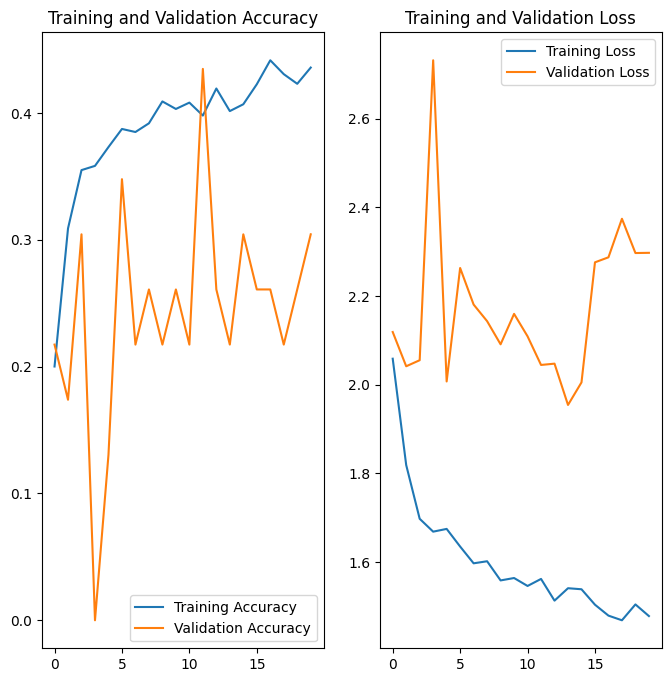

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

As we can see model with augmentation layers and dropouts does not perform well on training data itself, performing significantly worse.

**Displaying the number of samples for each class**

In [24]:
dataset_unbatched = tuple(train_ds.unbatch())
labels = []
for (image,label) in dataset_unbatched:
    labels.append(label.numpy())
labels = pd.Series(labels)

# adjustments
count = labels.value_counts().sort_index()
count.index = train_ds.class_names
print(count)


actinic keratosis             493
basal cell carcinoma          721
dermatofibroma                455
melanoma                      755
nevus                         677
pigmented benign keratosis    773
seborrheic keratosis          456
squamous cell carcinoma       569
vascular lesion               493
dtype: int64


**The findings are**

**Which class has the least number of samples?**

seborrheic keratosis has least number of samples.


**Which classes dominate the data in terms proportionate number of samples?**

The classes 'pigmented benign keratosis','melanoma', 'basal cell carcinoma',  
dominate in terms proportionate number of samples.
Clearly 'pigmented benign keratosis' and 'melanoma' dominate the data

**Class Imbalance**

In [25]:
pip install Augmentor

To use Augmentor, the following general procedure is followed:

1.Instantiate a Pipeline object pointing to a directory containing your initial image data set.

2.Define a number of operations to perform on this data set using your Pipeline object.

3.Execute these operations by calling the Pipeline’s sample() method.

In [26]:
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(str(data_dir_train) +'/'+ str(i))
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/My Drive/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F89547BA170>: 100%|██████████| 500/500 [00:23<00:00, 21.72 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/My Drive/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F88B19952D0>: 100%|██████████| 500/500 [00:21<00:00, 23.24 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/My Drive/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F89549998D0>: 100%|██████████| 500/500 [00:17<00:00, 28.02 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/My Drive/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F88B18B7A00>: 100%|██████████| 500/500 [01:24<00:00,  5.93 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/My Drive/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7F89546787C0>: 100%|██████████| 500/500 [01:30<00:00,  5.55 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/My Drive/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F895499AF80>: 100%|██████████| 500/500 [00:17<00:00, 28.97 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/My Drive/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F88B1997F40>: 100%|██████████| 500/500 [00:40<00:00, 12.40 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/My Drive/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F8954690D90>: 100%|██████████| 500/500 [00:17<00:00, 28.92 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/My Drive/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F8954999AB0>: 100%|██████████| 500/500 [00:17<00:00, 28.91 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [27]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

9000


**Dataset creation Model creation and Training**

In [28]:

batch_size = 32
img_height = 180
img_width = 180

In [29]:
data_dir_train = pathlib.Path("/content/gdrive/My Drive/Train")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 8992 files for training.


In [31]:

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


In [32]:
num_classes = 9

model3 = tf.keras.Sequential([
  tf.keras.layers.InputLayer(input_shape=(img_height, img_width, 3)),
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

**Model Creation**

In [33]:
model3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

**Model Training**

In [34]:
epochs = 20
history = model3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
281/281 [==============================] - 274s 946ms/step - loss: 1.7390 - accuracy: 0.3410 - val_loss: 1.4149 - val_accuracy: 0.4579
Epoch 2/20
281/281 [==============================] - 54s 189ms/step - loss: 1.2853 - accuracy: 0.5302 - val_loss: 1.1933 - val_accuracy: 0.5527
Epoch 3/20
281/281 [==============================] - 50s 175ms/step - loss: 0.9872 - accuracy: 0.6399 - val_loss: 0.9358 - val_accuracy: 0.6756
Epoch 4/20
281/281 [==============================] - 49s 172ms/step - loss: 0.7507 - accuracy: 0.7323 - val_loss: 1.1794 - val_accuracy: 0.5946
Epoch 5/20
281/281 [==============================] - 50s 175ms/step - loss: 0.5513 - accuracy: 0.8017 - val_loss: 0.6985 - val_accuracy: 0.7530
Epoch 6/20
281/281 [==============================] - 52s 182ms/step - loss: 0.4223 - accuracy: 0.8506 - val_loss: 0.5826 - val_accuracy: 0.7828
Epoch 7/20
281/281 [==============================] - 50s 176ms/step - loss: 0.3455 - accuracy: 0.8776 - val_loss: 0.4858 - val_a

**Visualize the model results**

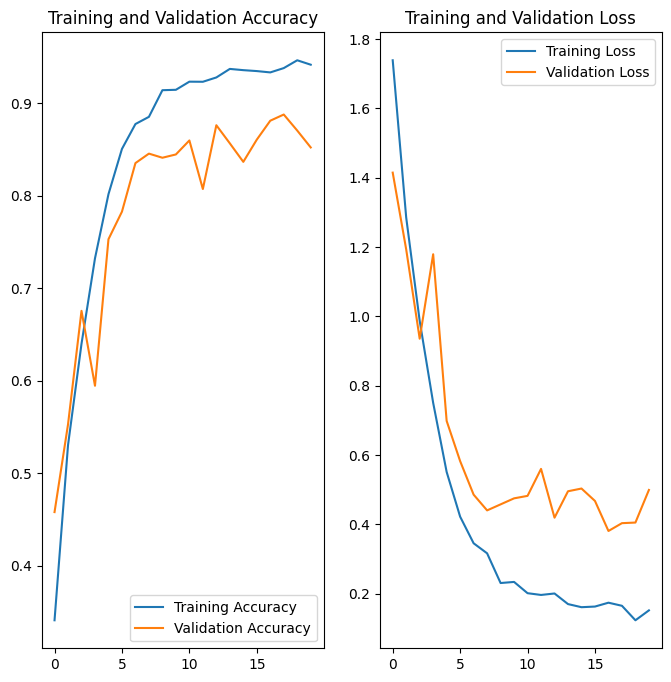

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The results with dataset augmentation shown significant improvement over previous models with Training accuracy of 0.9417 and Validation accuracy of
0.8522.It is clear that we got rid off underfitting and overfitting.
We can say that this model fits good.